In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import gpytorch
import lbg_forecast.priors_gp_massfunc as gpmf

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
54.77729389448207
39.648643329946054
26.797159997026746
16.638081394031133
9.521939653121681
5.622833342297504
4.6411626113926
4.366687012567222
4.135031516429292
3.9376284180539747
3.768143879437706
3.6217157327457032
3.494508032774462
3.38343731485661
3.285992997486379
3.200114745715523
3.124099551808109
3.0565338347237754
2.9962384219731035
2.942225777890164
2.893665843057181
2.849857462156964
2.8102057290426425
2.774204264984436
2.741419988166137
2.711480154303402
2.684063942477004
2.6588929330382842
2.6357254397158725
2.614350037471179
2.5945820807506976
2.576258669662275
2.5592369060047657
2.5433896700097316
2.5286048569484287
2.5147827539640564
2.5018340852044134
2.4896797353206885
2.4782483538326936
2.4674762965113493
2.4573062562497467
2.4476867482518307
2.438571396840056
2.4299180668804583
2.4216890428007765
2.4138499189870912
2.4063697

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


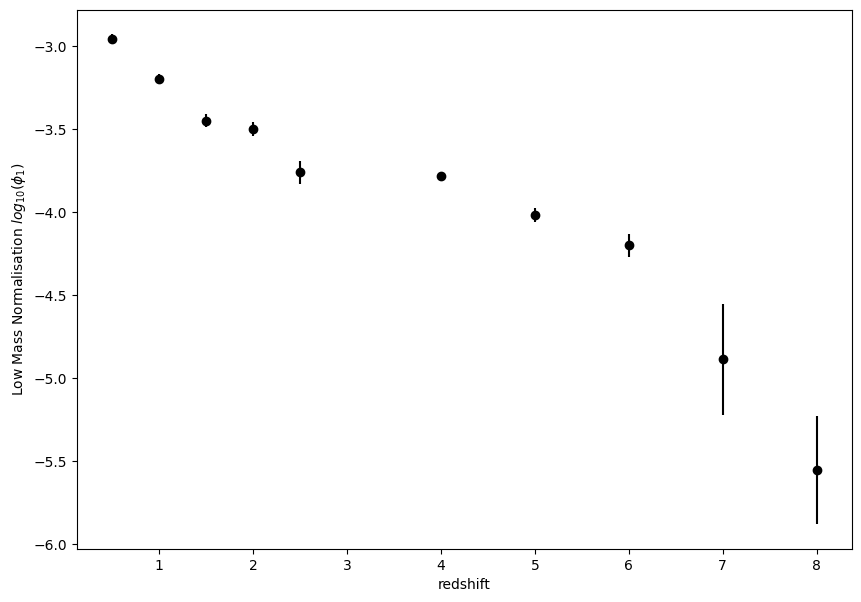

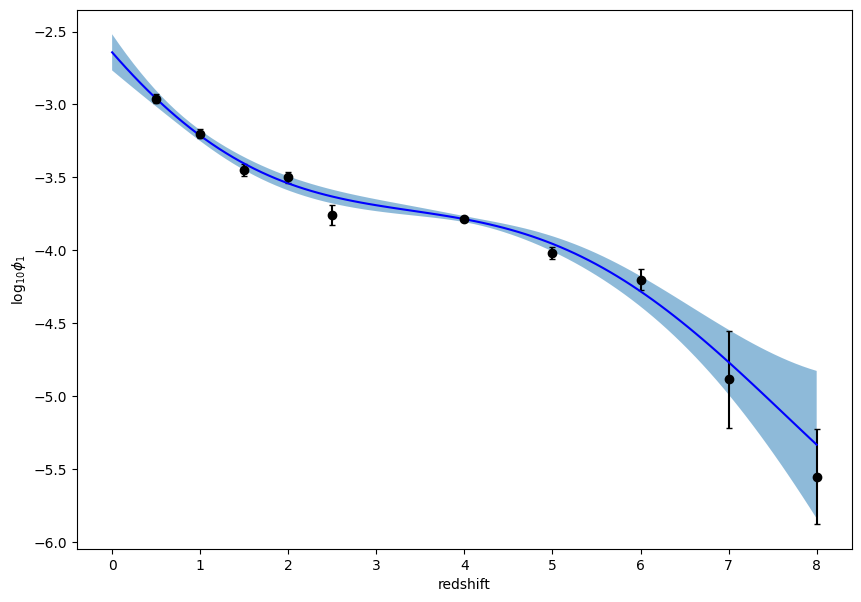

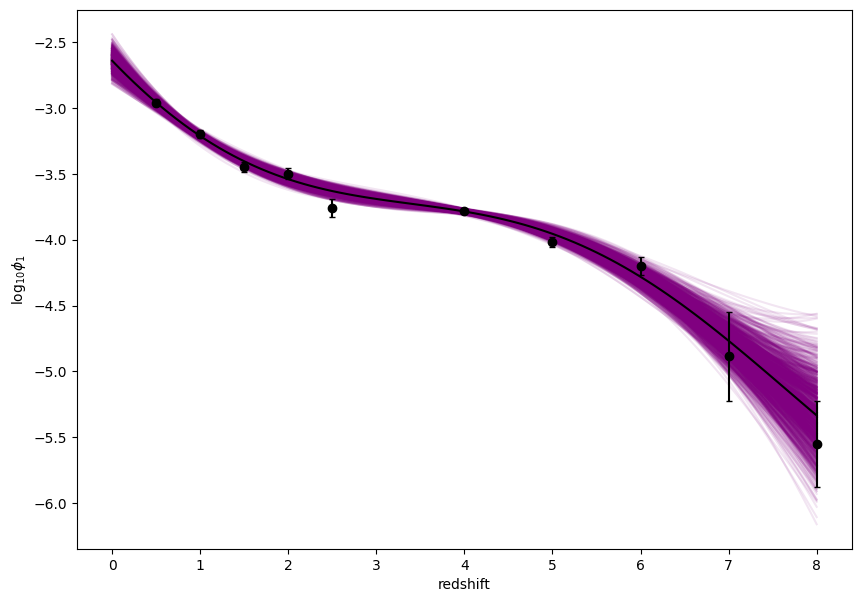

In [2]:
sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errs = gpmf.get_phi1_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_logphi1, sorted_train_logphi1_errs, torch.linspace(0, 8, 100), lengthscale=[1.0, 5.0], scalefactor=[-999, 999], lr=0.1, training_iter=20000, ylabel="$\mathrm{log}_{10}\phi_{1}$", name="phi1")


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
49.54839094520538
35.005069319755265
22.6641587245745
12.953115020587237
6.236632506760186
2.6998688908447415
2.045695683867114
2.077787020165252
2.129736824470648
2.1926162325017584
2.2588063872419264
2.322866660934713
2.3816050858690714
2.433623055115839
2.478707599540013
2.5173027491230706
2.5501441943024545
2.5780374502314674
2.601747999322737
2.621950892219485
2.639219333981475
2.6540286488755895
2.666769028998189
2.677759416686304
2.687259311412876
2.6954808702604964
2.7025984404903234
2.708754815127192
2.714069084600328
2.718639986277302
2.7225502969465474
2.7258701025511356
2.728658396447762
2.7309657013532123
2.7328349331886534
2.7343030771031076
2.7354020927579
2.736159164178801
2.7365981014458973
2.7367390884072478
2.736599930060891
2.736195376078647
2.7355381048485663
2.734638939768158
2.7335070150391894
2.732149269085184
2.7305714005

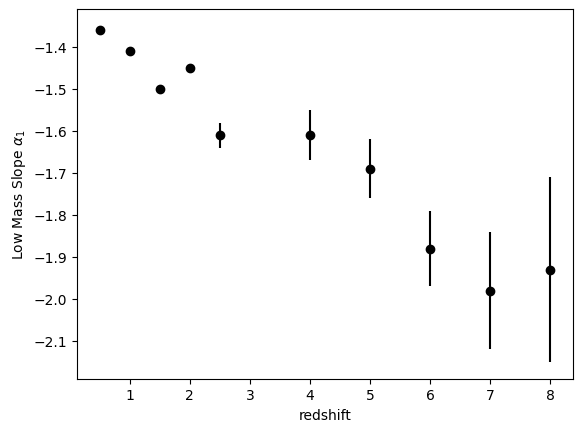

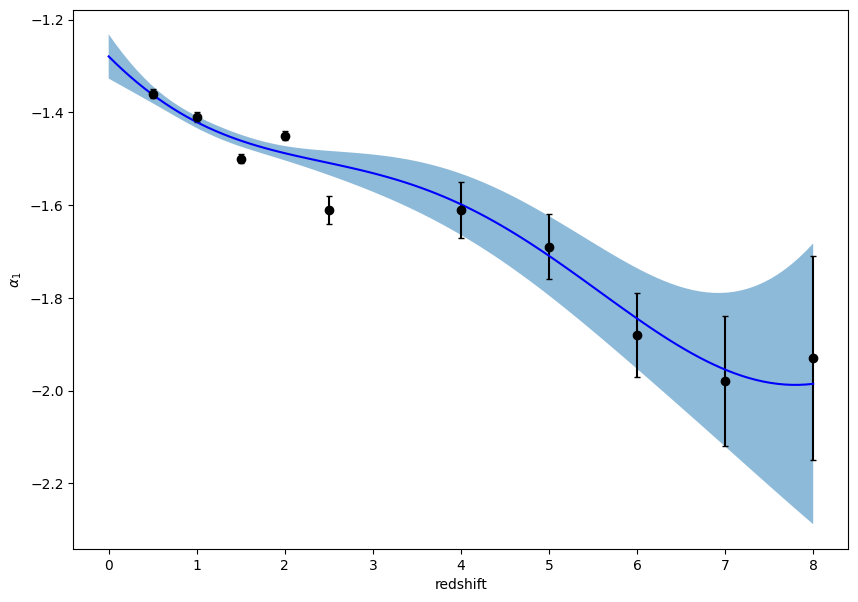

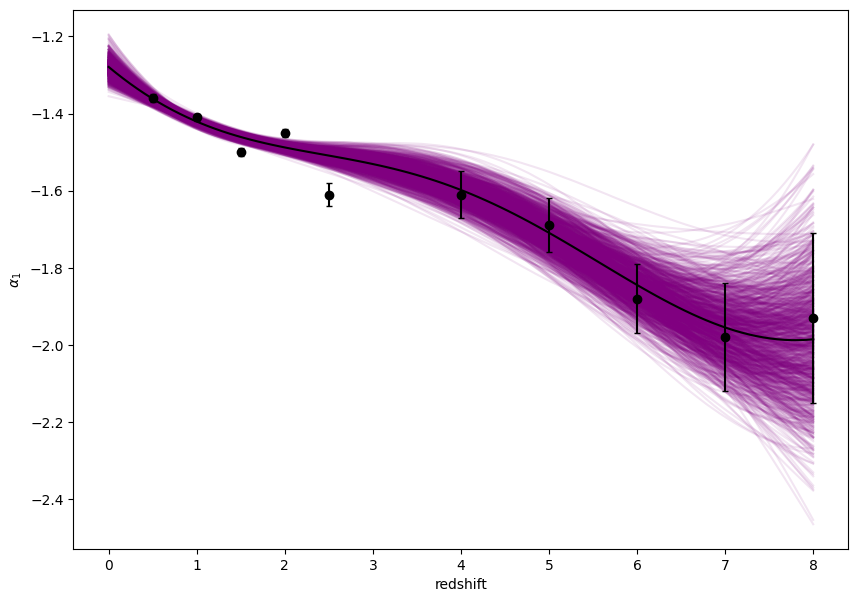

In [3]:
sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errs = gpmf.get_alpha1_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_alpha1, sorted_train_alpha1_errs, torch.linspace(0.0, 8.0, 100), lengthscale=[1.0, 5.0], scalefactor=[-999, 999], lr=0.1, training_iter=20000, ylabel="$\\alpha_{1}$", name="alpha1")

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
87.42106766705125
68.73471629010297
52.74426277545977
39.83540160318422
30.330470789972264
24.38981440555089
21.706693137770287
19.981371050383487
18.516364542475834
17.26044788919603
16.174888122473355
15.229829036486294
14.401851348084739
13.672317278196534
13.026197227304959
12.451238539334996
11.937353759288348
11.476171903435416
11.060698523840255
10.685048977688675
10.344241923868953
10.034039488149627
9.750820607833749
9.491471429482495
9.25330862167694
9.034005858932407
8.831541116066763
8.64414938497139
8.470286317589638
8.308593891053826
8.157876238532351
8.017077803160294
7.885260800779849
7.761594871713532
7.645340436683497
7.535835949591404
7.432492200766876
7.334778988158526
7.242221868627264
7.154394663197673
7.070911275747468
6.991425264766415
6.915622729839552
6.84321998856247
6.773959093416913
6.7076071345989705
6.64395180586698

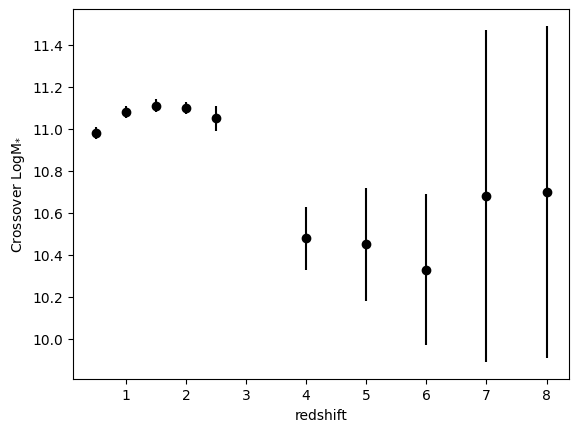

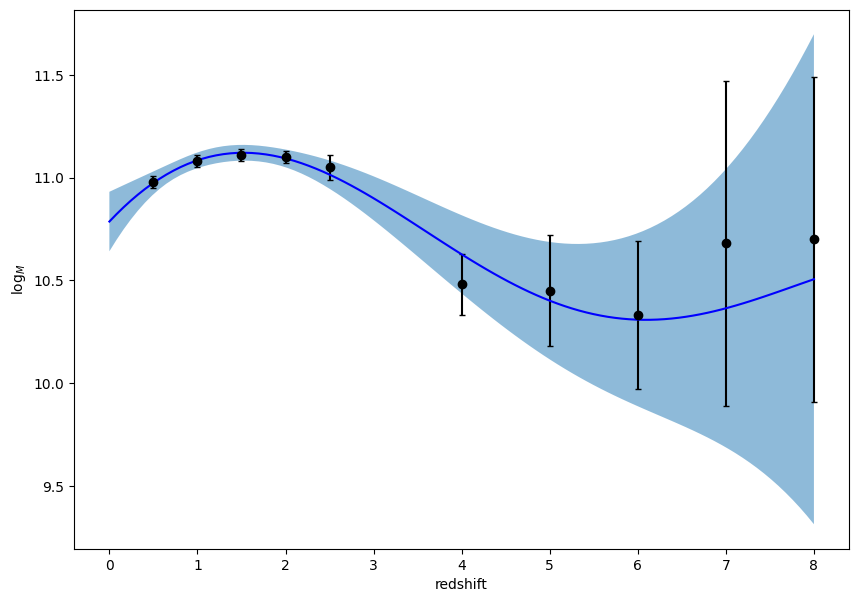

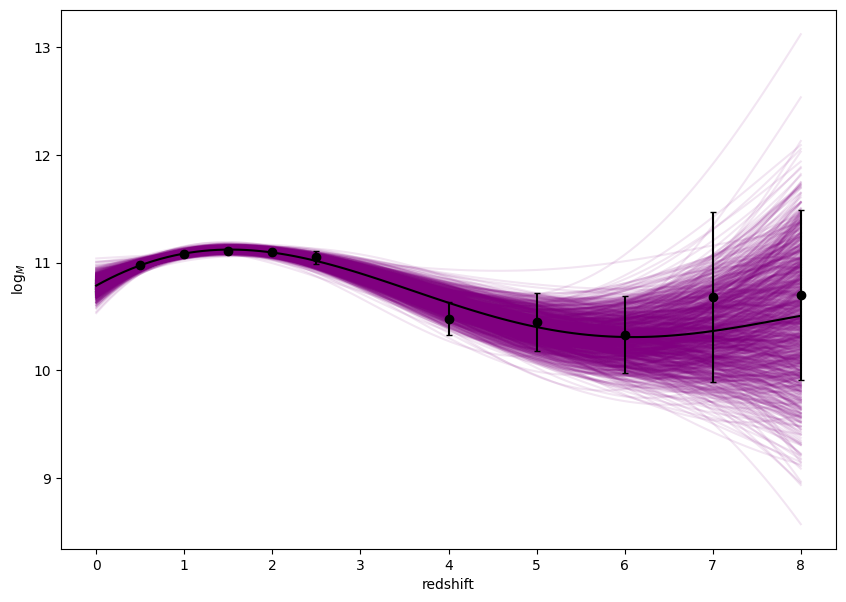

In [4]:
sorted_train_redshift, sorted_train_logm, sorted_train_logm_errs = gpmf.get_logm_data(plotting=True)
gpmf.gp(sorted_train_redshift, sorted_train_logm, sorted_train_logm_errs, torch.linspace(0, 8, 100), lengthscale=[1.0, 5.0], scalefactor=[-999, 999], lr=0.1, training_iter=10000, ylabel="$\mathrm{log}_{M}$", name="logm")